<h1 style="text-align:center;font-size:30px;" > Quora Question Pair Similarity </h1>

<h1> 1. Business Problem </h1>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


## 2. Problem Statement 
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2>3. Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h2> 4. Data Overview </h2>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

Quick Glance at datapoints

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>


<b>0 -> Not Similar Questions</b>

<b>1 -> Similar Question</b>

<h3> 4.1 Performance Metric </h3>

* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

Now that problem statement is understood, time to map the business problem with Machine Learning

### First Things First

In [1]:
# importing basic packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Importing dataset 

In [2]:
data = pd.read_csv("train.csv")

## 5. Exploartory Data Analysis 

In [3]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
data.shape

(404290, 6)

" We have total 404290 datapoints "

In [9]:
# Checking number of similar and non similar questions
data["is_duplicate"].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

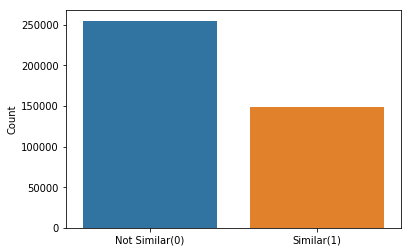

In [15]:
# Plotting barplot of similar and non similar questions
sns.barplot(x = ["Not Similar(0)", "Similar(1)"],y=data["is_duplicate"].value_counts())
plt.ylabel("Count")
plt.show()

In [36]:
print("We have {}% of Non similar questions".format(round(data["is_duplicate"].value_counts()[0]*100/data.shape[0]),2))
print()
print("We have {}% of Similar questions".format(round(data["is_duplicate"].value_counts()[1]*100/data.shape[0])))

We have 63.0% of Non similar questions

We have 37.0% of Similar questions


#### Number of Unique Questions

In [137]:
# STacking question1 and question2 datapoints
all_questions = pd.Series(data.qid1.tolist()+data.qid2.tolist())

print("Number of Unique Questions : ", len(all_questions.unique()))

# Getting the length the of pd Series having the unique questions repeated more than once
more_than_once = all_questions.value_counts()[all_questions.value_counts() > 1]
print("Number of unique questions repeated more than once : " ,len(more_than_once))

print("Highest time a single question is repeated : ", max(all_questions.value_counts()))

Number of Unique Questions :  537933
Number of unique questions repeated more than once :  111780
Highest time a single question is repeated :  157


Out of number all unique questions ~20% are repeated more than once

#### Checking for duplicates

In [138]:
no_of_duplicates = data[data.question1 == data.question2]
print("Number of Duplicate questions are : ", len(no_of_duplicates))

Number of Duplicate questions are :  0


#### Checking for any NULL values

In [139]:
null_values = data[data.isnull().any(1)]
null_values

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


There are three null values into dataset. Lets fill them with empty string

In [5]:
# Filling the null values
data = data.fillna(" ")

In [6]:
# Checking again if there is any null value
len(data[data.isnull().any(1)])

0

####  Number of Occurences of each question

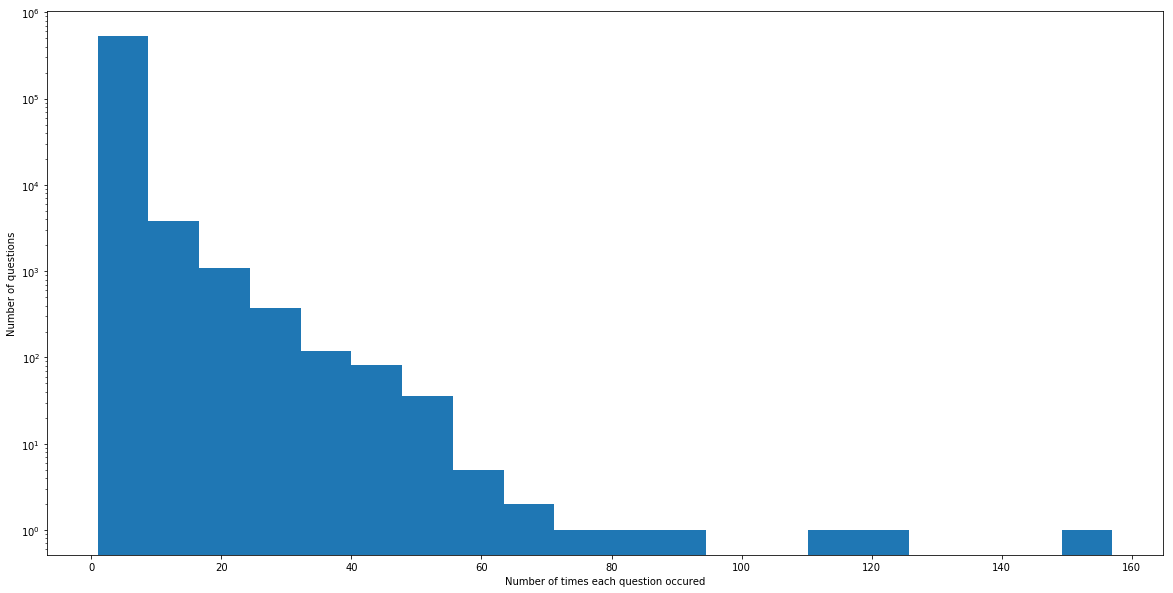

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(all_questions.value_counts(), bins=20)
plt.yscale('log', nonposy='clip')
plt.xlabel("Number of times each question occured")
plt.ylabel("Number of questions")
plt.show()

<h2>6. Basic Feature Extraction (before cleaning), Data Preprocessing </h2>

Let's construct few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
# Constructing first feature Freq_qid1
freq1 = data.qid1.value_counts()
data["freq_qid1"] = data.qid1.apply(lambda x : freq1[x])

# Constructing feature Freq_qid2
freq2 = data.qid2.value_counts()
data["freq_qid2"] = data.qid2.apply(lambda x : freq2[x])

# Constructing feature q1len1
data["q1len"] = data.question1.str.len()

# Constructing feature q1len2
data["q2len"] = data.question2.str.len()

# Constructing feature q1_n_words
data["q1_n_words"] = data.question1.apply(lambda x : len(x.split()))

# Constructing feature q1_n_words
data["q2_n_words"] = data.question2.apply(lambda x : len(x.split()))

# Constructing feature length of no.of Common words in question1 and question2
def get_length(row):
    q1 = set(row.question1.lower().split())
    q2 = set(row.question2.lower().split())
    return len(q1 & q2)*1.0

data['word_Common'] = data.apply(get_length, axis=1)

# Constructing feature total length of  words in question1 and question2
def word_length(row):
    q1 = set(row.question1.lower().strip().split())
    q2 = set(row.question2.lower().strip().split())
    total_len = len(q1) + len(q2)
    return total_len*1.0
data['word_Total'] = data.apply(word_length, axis=1)

# function for finding word share in question1 and question2
def word_share(row):
    common = row.word_Common
    total = row.word_Total
    share = (common/total)*1.0
    return share*1.0

# Constructing feature of word share in question1 and question2
data["word_share"] = data.apply(word_share, axis=1)

# feature of sum and difference in frequncies
data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

In [ ]:
# saving data for future reference
data.to_csv("featured_data_set_without_clean", index=False)

In [168]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h2>7. Analysis of some of the extracted features </h2>

In [170]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 0].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 0].shape[0])

Minimum length of the questions in question1 :  0
Minimum length of the questions in question2 :  0
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 2


The Zero is for those which were NAN

<h4>Plots of  Feature: word_share </h4>

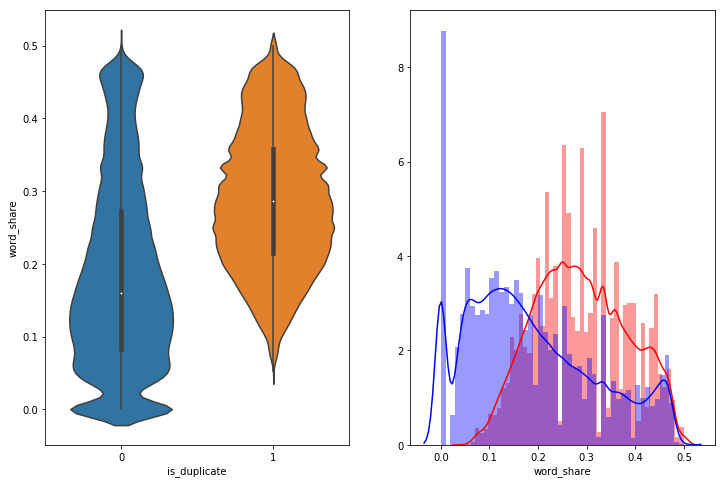

In [201]:
plt.figure(figsize=(12, 8))
# Voilin plot
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = data)

# Pdf Plot
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'], label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()


- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4>Plots of  Feature: word_common </h4>

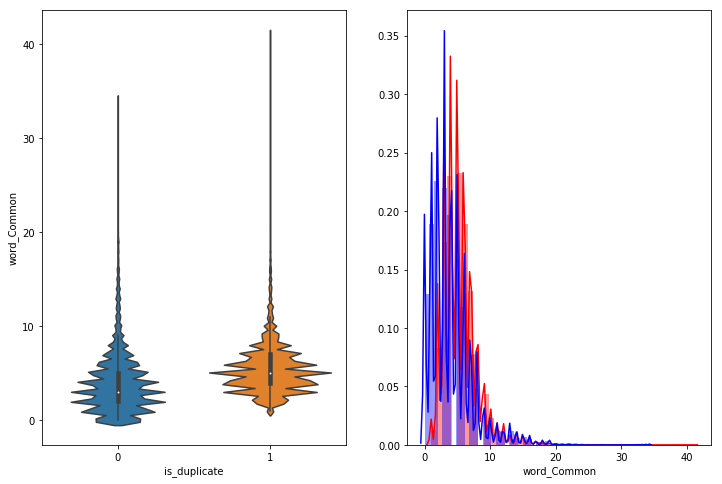

In [200]:
plt.figure(figsize=(12,8))

# Voilin plot
plt.subplot(1,2,1)
sns.violinplot(data=data, x="is_duplicate", y="word_Common")

# Pdf Plot
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

Further Procedures are followed in next notebook